In [4]:
import libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import yfinance as yf
import duckdb

import io
from urllib.request import urlopen
import zipfile
import os

from menuinst.platforms.win_utils.knownfolders import folder_path
from sipbuild.generator.parser.tokens import keywords
from sympy.abc import alpha

In [5]:
# Parameters
start_date = '2018-01-01'
end_date = '2024-10-15'
folder_path = r"filter\stocks_to_keywords_specific"

In [6]:
input_source = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
print(input_source)

['AAPL_apple.csv', 'ABBV_abbvie.csv', 'ADM_archer-daniels.csv', 'BP_bp.csv', 'COP_conocophillips.csv', 'CTVA_corteva.csv', 'CVX_chevron.csv', 'DE_deere.csv', 'DOW_dow-jones.csv', 'FCX_freeport-mcmoran.csv', 'JNJ_johnson-and-johnson.csv', 'JPM_jpmorgan-chase.csv', 'KO_coca-cola.csv', 'MA_mastercard.csv', 'MSFT_microsoft.csv', 'NEM_newmont-corporation.csv', 'NVDA_nvidia.csv', 'PEP_pepsico.csv', 'PFE_pfizer.csv', 'PG_procter-and-gamble.csv', 'TMUS_t-mobile.csv', 'T_att.csv', 'VZ_verizon.csv', 'V_visa.csv', 'XOM_exxon-mobil.csv']


In [15]:
moving_avg = lambda series, windows, periods : (series.rolling(window=f'{windows[0]}D', min_periods=periods[0]).mean()).rolling(window=f'{windows[1]}D', min_periods=periods[1]).mean().dropna()

In [16]:
for file in input_source:

    stock_code = file.split('_')[0]
    company_name = file.split('_')[1].split('.')[0]
    print(f'Running: {stock_code}, {company_name.capitalize()}')
    
    df = pd.read_csv(os.path.join(folder_path, file)) # article data
    stock_data = yf.download(stock_code, start=start_date, end=end_date, progress=False)

    # Prepare columns needed
    df.rename(columns={'AvgTone':'Tone'}, inplace=True)
    df.rename(columns={'GoldsteinScale':'Goldstein'}, inplace=True)
    df.drop(columns=['NumArticles'], inplace=True)
    df.drop(columns=['NumMentions'], inplace=True)

    full_date_range = pd.date_range(start_date, end_date)
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date")
    
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    count_per_day = df.groupby('Date').size().reset_index(name='Count')
    goldstein_per_day = df.groupby('Date')['Goldstein'].sum().reset_index(name='Goldstein')
    tone_per_day = df.groupby('Date')['Tone'].sum().reset_index(name='Tone')

    df = pd.DataFrame({'Date': full_date_range}).merge(count_per_day, on='Date', how='left')
    df = df.merge(goldstein_per_day, on='Date', how='left')
    df = df.merge(tone_per_day, on='Date', how='left')

    # raw
    df['Count'].fillna(0, inplace=True)
    df['Goldstein'].fillna(0, inplace=True)
    df['Tone'].fillna(0, inplace=True)
    df.set_index('Date', inplace=True)

    # raw rolling average
    windows = [90, 30]
    periods = [30, 1]
    df['C_RA'] = moving_avg(df['Count'], windows, periods)
    df['G_RA'] = moving_avg(df['Goldstein'], windows, periods)
    df['T_RA'] = moving_avg(df['Tone'], windows, periods)
    
    # diff 1
    # raw rolling
    df['C_DIFF1_RA'] = moving_avg(df['Count'], windows, periods)
    df['G_DIFF1_RA'] = moving_avg(df['Goldstein'], windows, periods)
    df['T_DIFF1_RA'] = moving_avg(df['Tone'], windows, periods)
    
    # diff 2
    # raw rolling
    df['C_DIFF2_RA'] = moving_avg(df['C_DIFF1_RA'], windows, periods)
    df['G_DIFF2_RA'] = moving_avg(df['G_DIFF1_RA'], windows, periods)
    df['T_DIFF2_RA'] = moving_avg(df['T_DIFF1_RA'], windows, periods)

    display(df)

    break


Running: AAPL, Apple


,Count,Goldstein,Tone,C_RA,G_RA,T_RA,C_DIFF1_RA,G_DIFF1_RA,T_DIFF1_RA,C_DIFF2_RA,G_DIFF2_RA,T_DIFF2_RA
Date,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.0,-2.0,-6.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1.0,7.0,-1.212121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11,0.0,0.0,0.000000,3.220741,2.729889,-0.127245,3.220741,2.729889,-0.127245,4.194686,1.902276,-1.826061
2024-10-12,4.0,-2.6,-9.070363,3.218148,2.791778,-0.116232,3.218148,2.791778,-0.116232,4.173872,1.899860,-1.761712
2024-10-13,1.0,7.0,3.521127,3.215556,2.852630,-0.107947,3.215556,2.852630,-0.107947,4.153099,1.897746,-1.698581


In [76]:



df = pd.read_csv("C:\dev\dm-2024-t1-pj-eda-honeybadgerlover645\eda\q1\\filter\stocks_to_keywords_specific\AAPL_apple.csv")
# df = pd.read_csv("C:\dev\dm-2024-t1-pj-eda-honeybadgerlover645\eda\q1\\filter\stocks_to_keywords_specific\\MSFT_microsoft.csv")
stocks = yf.download('AAPL', start=start_date, end=end_date, progress=False)

df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date")

,GoldsteinScale,AvgTone,NumArticles,NumMentions,SOURCEURL,Date
2724,-2.0,1.075269,10.0,10.0,https://gulfnews.com/technology/consumer-elect...,1920-01-01
2727,6.0,-2.962963,3.0,3.0,https://www.thetimes.co.uk/edition/business/im...,1920-01-02
2728,6.0,1.063076,10.0,10.0,https://www.businessinsider.com.au/oneplus-pho...,1920-01-02
2729,8.0,4.633205,6.0,6.0,https://www.cnbc.com/2020/01/02/apple-signs-ex...,1920-01-02
2730,7.0,6.534091,5.0,5.0,http://www.startribune.com/apple-google-and-am...,1920-01-02
...,...,...,...,...,...,...
9819,3.0,-1.922269,70.0,70.0,https://www.forbes.com/sites/ewanspence/2024/1...,2024-10-14
9822,7.0,-1.011378,4.0,4.0,https://www.newsweek.com/apples-iphone-hits-sa...,2024-10-15
9820,3.0,5.054214,50.0,50.0,https://www.cnet.com/tech/mobile/apple-reporte...,2024-10-15
9821,1.0,-0.259067,2.0,2.0,https://www.abc.net.au/news/2024-10-15/malala-...,2024-10-15


In [77]:
full_date_range = pd.date_range(start_date, end_date)

In [78]:
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [79]:
count_per_day = df.groupby('Date').size().reset_index(name='EventCount')
goldstein_per_day = df.groupby('Date')['GoldsteinScale'].sum().reset_index(name='GoldsteinScale')
avg_tone_per_day = df.groupby('Date')['AvgTone'].sum().reset_index(name='AvgTone')

In [80]:
df_full = pd.DataFrame({'Date': full_date_range}).merge(count_per_day, on='Date', how='left')
df_full = df_full.merge(goldstein_per_day, on='Date', how='left')
df_full = df_full.merge(avg_tone_per_day, on='Date', how='left')

df_full['EventCount'].fillna(0, inplace=True)
df_full['GoldsteinScale'].fillna(0, inplace=True)
df_full['AvgTone'].fillna(0, inplace=True)

df_full.set_index('Date', inplace=True)
df_full


,EventCount,GoldsteinScale,AvgTone
Date,,,
2018-01-01,0.0,0.0,0.000000
2018-01-02,0.0,0.0,0.000000
2018-01-03,1.0,-2.0,-6.666667
2018-01-04,1.0,7.0,-1.212121
2018-01-05,0.0,0.0,0.000000
...,...,...,...
2024-10-11,0.0,0.0,0.000000
2024-10-12,4.0,-2.6,-9.070363
2024-10-13,1.0,7.0,3.521127


In [81]:
# df_full['GC'] = df_full['EventCount'] * df_full['GoldsteinScale']
# df_full['AC'] = df_full['EventCount'] * df_full['AvgTone']

df_full['GC'] = df_full['GoldsteinScale']
df_full['AC'] = df_full['AvgTone']

In [82]:
window = 60
df_full['RollingAvg_Events'] = df_full['EventCount'].rolling(window=f'{window}D', min_periods=1).mean()
df_full['RollingAvg_GC'] = df_full['GC'].rolling(f'{window}D', min_periods=1).mean()
df_full['RollingAvg_AC'] = df_full['AC'].rolling(f'{window}D', min_periods=1).mean()

In [83]:
df_full['RollingAvg_Events'].fillna(0, inplace=True)
df_full['RollingAvg_GC'].fillna(0, inplace=True)
df_full['RollingAvg_AC'].fillna(0, inplace=True)

In [84]:

output = df_full

output

,EventCount,GoldsteinScale,AvgTone,GC,AC,RollingAvg_Events,RollingAvg_GC,RollingAvg_AC
Date,,,,,,,,
2018-01-01,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2018-01-03,1.0,-2.0,-6.666667,-2.0,-6.666667,0.333333,-0.666667,-2.222222
2018-01-04,1.0,7.0,-1.212121,7.0,-1.212121,0.500000,1.250000,-1.969697
2018-01-05,0.0,0.0,0.000000,0.0,0.000000,0.400000,1.000000,-1.575758
...,...,...,...,...,...,...,...,...
2024-10-11,0.0,0.0,0.000000,0.0,0.000000,3.516667,4.801667,0.195294
2024-10-12,4.0,-2.6,-9.070363,-2.6,-9.070363,3.550000,4.758333,0.020369
2024-10-13,1.0,7.0,3.521127,7.0,3.521127,3.500000,4.686667,0.070353


In [85]:
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.568932,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.561871,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.750278,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.214237,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.061146,82271200
...,...,...,...,...,...,...
2024-10-08,224.300003,225.979996,223.250000,225.770004,225.770004,31855700
2024-10-09,225.229996,229.750000,224.830002,229.539993,229.539993,33591100
2024-10-10,227.779999,229.500000,227.169998,229.039993,229.039993,28183500


In [229]:
def smooth(series:pd.Series, window, poly_order):
    return pd.Series(index=series.index,data=savgol_filter(series.fillna(0), window, poly_order))

Experiment with pykalman

In [259]:
from pykalman import KalmanFilter
def kalman_filter(series: pd.Series, initial_state_mean=0,  observation_covariance=90, transition_covariance=0.8):
    kf = KalmanFilter(
        initial_state_mean=0,  # Initial state estimate
        n_dim_obs=1,           # Number of observation dimensions
        observation_covariance=observation_covariance,  # Measurement uncertainty
        transition_covariance=transition_covariance  # Process uncertainty
    )
    
    
    state_means, state_covariances = kf.filter(series)
    
    return pd.Series(state_means.reshape(-1), index=series.index)



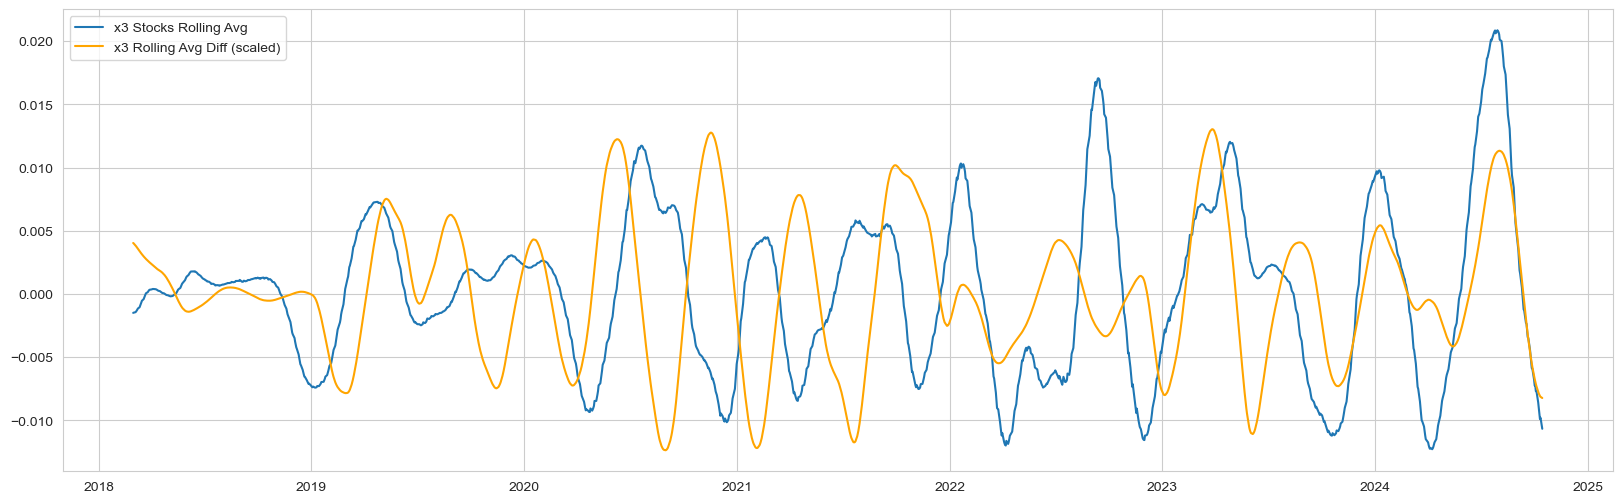

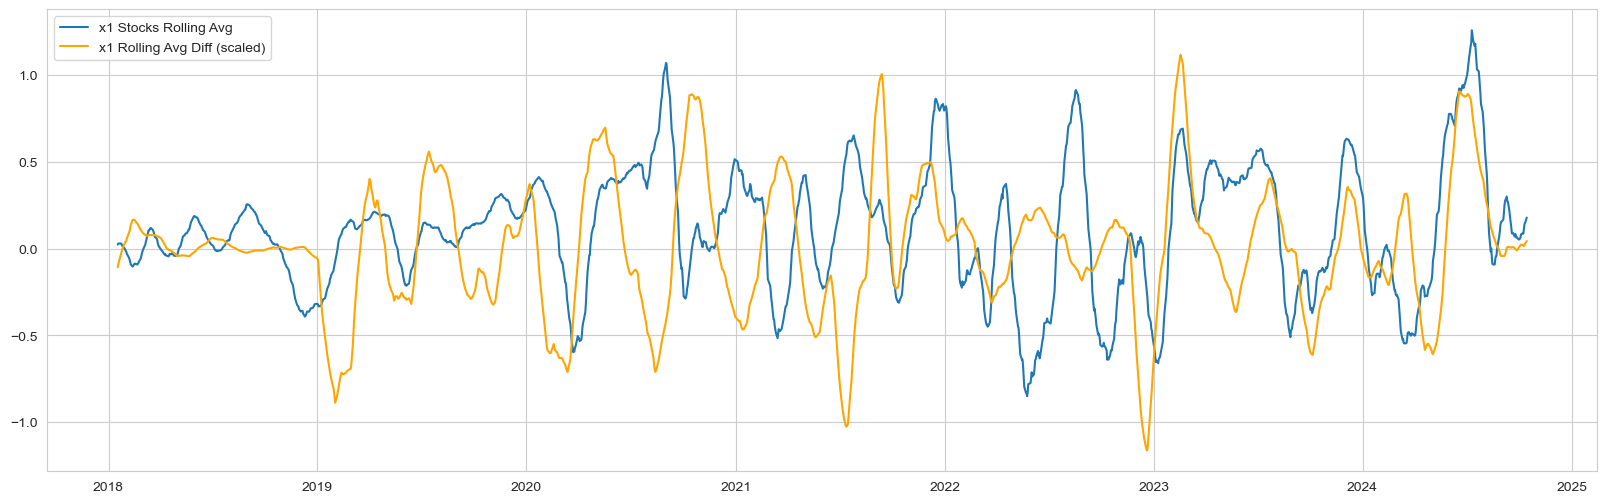

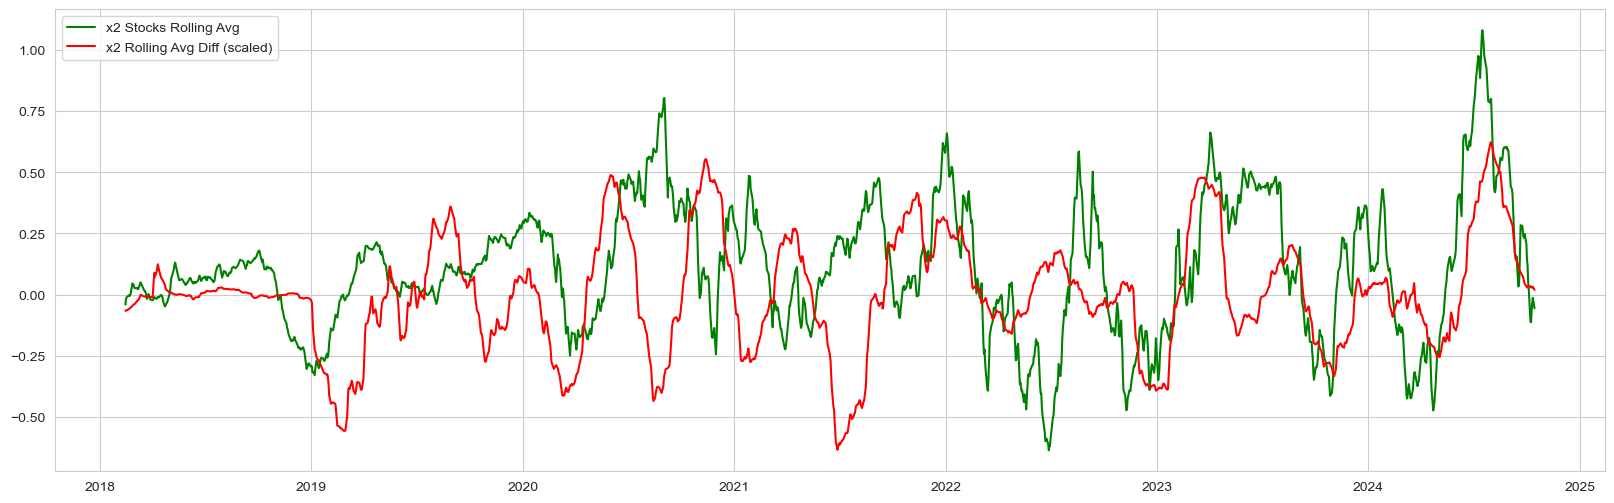

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.signal import savgol_filter



stocks_diff = stocks['Close'].diff().dropna()
rolling_avg_diff = output['RollingAvg_AC'].diff().dropna()

stocks_rolling_avg = stocks_diff.rolling('3D', min_periods=1).mean()
rolling_avg_rolling = rolling_avg_diff.rolling('3D', min_periods=1).mean()

stocks_rolling_avg =  kalman_filter(stocks_diff, initial_state_mean=stocks_diff.iloc(0))
rolling_avg_rolling = kalman_filter(rolling_avg_diff, initial_state_mean=rolling_avg_diff.iloc(0))
stocks_rolling_avg = stocks_rolling_avg.rolling('30D', min_periods=10).mean()
rolling_avg_rolling = rolling_avg_rolling.rolling('30D', min_periods=10).mean()



# stocks_rolling_avg =  pd.Series(index=stocks_rolling_avg.index,data=savgol_filter(stocks_rolling_avg, 30, 3))
# rolling_avg_rolling = pd.Series(index=rolling_avg_rolling.index,data=savgol_filter(rolling_avg_rolling, 30, 3))


x1 = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
              rolling_avg_rolling.rename('rolling_avg_rolling'),
              left_index=True, right_index=True, how='inner').dropna()

stocks_diff = stocks_rolling_avg.diff().dropna()
rolling_avg_diff = rolling_avg_rolling.diff().dropna()


stocks_rolling_avg =  kalman_filter(stocks_diff)
rolling_avg_rolling = kalman_filter(rolling_avg_diff)
stocks_rolling_avg =  kalman_filter(stocks_rolling_avg)
rolling_avg_rolling = kalman_filter(rolling_avg_rolling)
stocks_rolling_avg = stocks_rolling_avg.rolling('90D', min_periods=30).mean()
rolling_avg_rolling = rolling_avg_rolling.rolling('90D', min_periods=30).mean()


# stocks_rolling_avg = stocks_rolling_avg.rolling('30D', min_periods=10).mean()
# rolling_avg_rolling = rolling_avg_rolling.rolling('30D', min_periods=10).mean()

x3 = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
              rolling_avg_rolling.rename('rolling_avg_rolling'),
              left_index=True, right_index=True, how='inner').dropna()

plt.figure(figsize=(20, 6))
plt.plot(x3.index, x3["stocks_rolling_avg"], label='x3 Stocks Rolling Avg')
plt.plot(x3.index, x3["rolling_avg_rolling"]*5, label='x3 Rolling Avg Diff (scaled)', color='orange')
plt.legend()
plt.show()



stocks_diff = stocks['Close'].diff().dropna()
rolling_avg_diff = output['RollingAvg_AC'].diff().dropna()

stocks_rolling_avg = stocks_diff.rolling('90D', min_periods=30).mean()
rolling_avg_rolling = rolling_avg_diff.rolling('90D', min_periods=30).mean()
stocks_rolling_avg = stocks_rolling_avg.rolling('3D', min_periods=1).mean()
rolling_avg_rolling = rolling_avg_rolling.rolling('3D', min_periods=1).mean()

# stocks_rolling_avg =  pd.Series(index=stocks_rolling_avg.index,data=savgol_filter(stocks_rolling_avg.fillna(0), 200, 2))
# rolling_avg_rolling = pd.Series(index=rolling_avg_rolling.index,data=savgol_filter(rolling_avg_rolling.fillna(0), 200, 2))


x2 = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
              rolling_avg_rolling.rename('rolling_avg_rolling'),
              left_index=True, right_index=True, how='inner').dropna()


plt.figure(figsize=(20, 6))
plt.plot(x1.index, x1["stocks_rolling_avg"], label='x1 Stocks Rolling Avg')
plt.plot(x1.index, x1["rolling_avg_rolling"]*5, label='x1 Rolling Avg Diff (scaled)', color='orange')
plt.legend()
plt.show()


plt.figure(figsize=(20, 6))
plt.plot(x2.index, x2["stocks_rolling_avg"], label='x2 Stocks Rolling Avg', color='green')
plt.plot(x2.index, x2["rolling_avg_rolling"]*5, label='x2 Rolling Avg Diff (scaled)', color='red')
plt.legend()
plt.show()

Experiment with low pass filtering

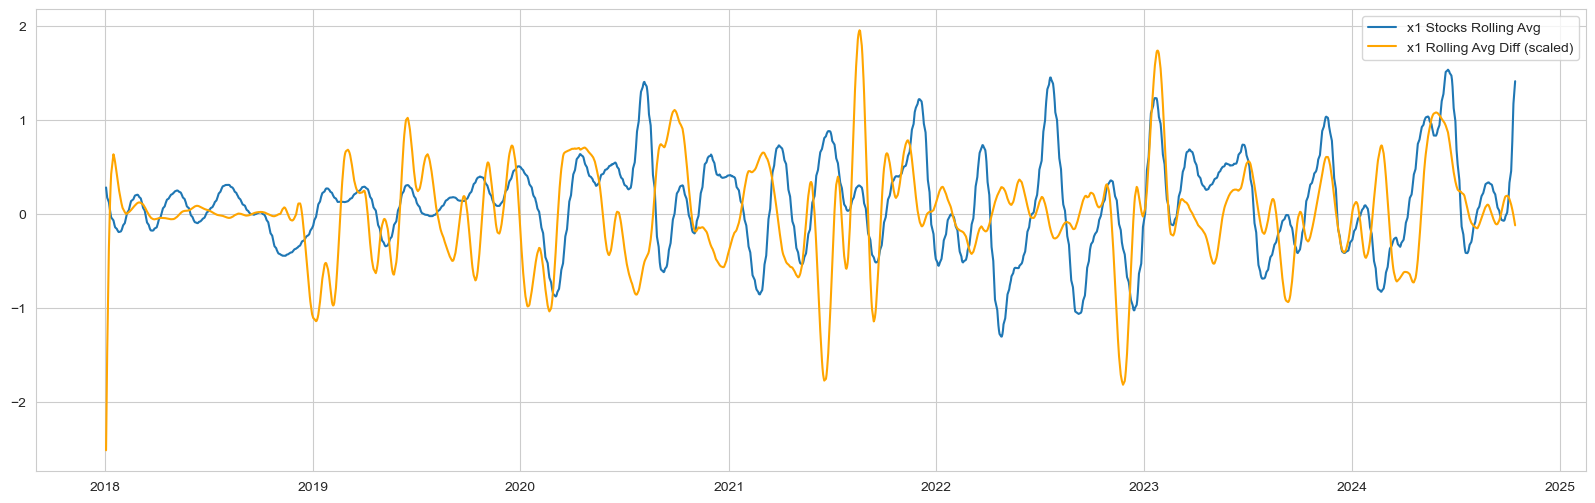

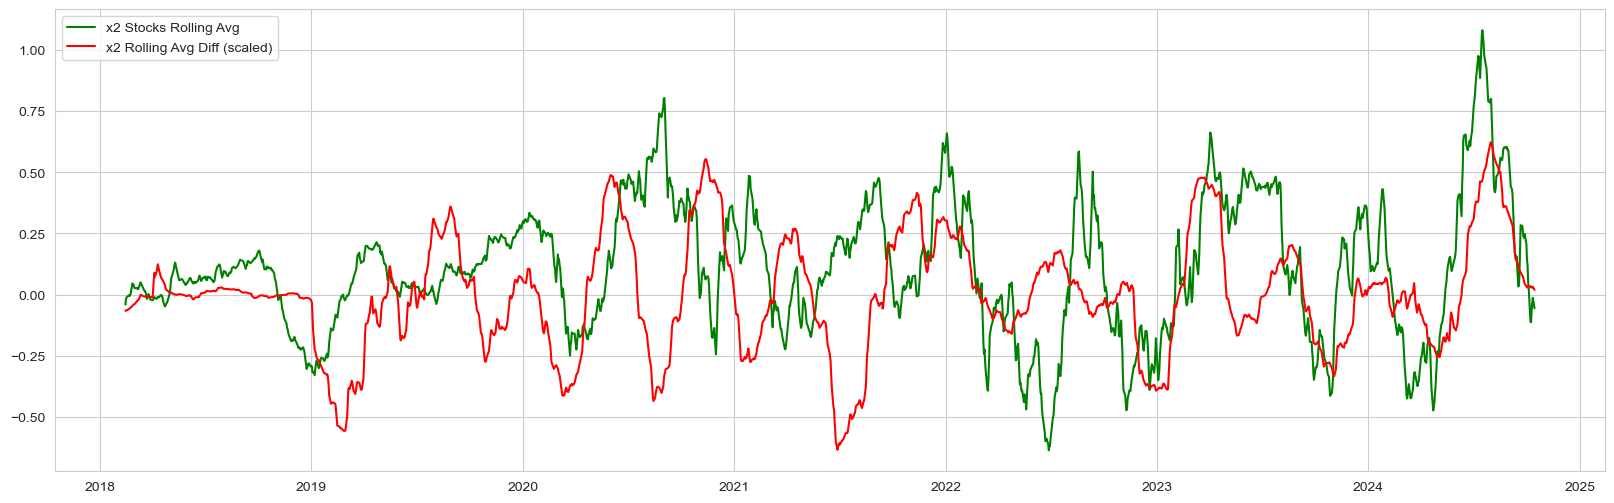

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.signal import savgol_filter



stocks_diff = stocks['Close'].diff().dropna()
rolling_avg_diff = output['RollingAvg_AC'].diff().dropna()


stocks_rolling_avg =  pd.Series(index=stocks_diff.index,data=savgol_filter(stocks_diff, 90, 7))
rolling_avg_rolling = pd.Series(index=rolling_avg_diff.index,data=savgol_filter(rolling_avg_diff, 90, 7))
stocks_rolling_avg =  pd.Series(index=stocks_rolling_avg.index,data=savgol_filter(stocks_rolling_avg, 30, 3))
rolling_avg_rolling = pd.Series(index=rolling_avg_rolling.index,data=savgol_filter(rolling_avg_rolling, 30, 3))


x1 = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
                               rolling_avg_rolling.rename('rolling_avg_rolling'),
                               left_index=True, right_index=True, how='inner').dropna()



stocks_diff = stocks['Close'].diff().dropna()
rolling_avg_diff = output['RollingAvg_AC'].diff().dropna()

stocks_rolling_avg = stocks_diff.rolling('90D', min_periods=30).mean()
rolling_avg_rolling = rolling_avg_diff.rolling('90D', min_periods=30).mean()
stocks_rolling_avg = stocks_rolling_avg.rolling('3D', min_periods=1).mean()
rolling_avg_rolling = rolling_avg_rolling.rolling('3D', min_periods=1).mean()

# stocks_rolling_avg =  pd.Series(index=stocks_rolling_avg.index,data=savgol_filter(stocks_rolling_avg.fillna(0), 200, 2))
# rolling_avg_rolling = pd.Series(index=rolling_avg_rolling.index,data=savgol_filter(rolling_avg_rolling.fillna(0), 200, 2))


x2 = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
                               rolling_avg_rolling.rename('rolling_avg_rolling'),
                               left_index=True, right_index=True, how='inner').dropna()


plt.figure(figsize=(20, 6))
plt.plot(x1.index, x1["stocks_rolling_avg"], label='x1 Stocks Rolling Avg')
plt.plot(x1.index, x1["rolling_avg_rolling"]*5, label='x1 Rolling Avg Diff (scaled)', color='orange')


plt.legend()
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(x2.index, x2["stocks_rolling_avg"], label='x2 Stocks Rolling Avg', color='green')
plt.plot(x2.index, x2["rolling_avg_rolling"]*5, label='x2 Rolling Avg Diff (scaled)', color='red')
plt.legend()
plt.show()

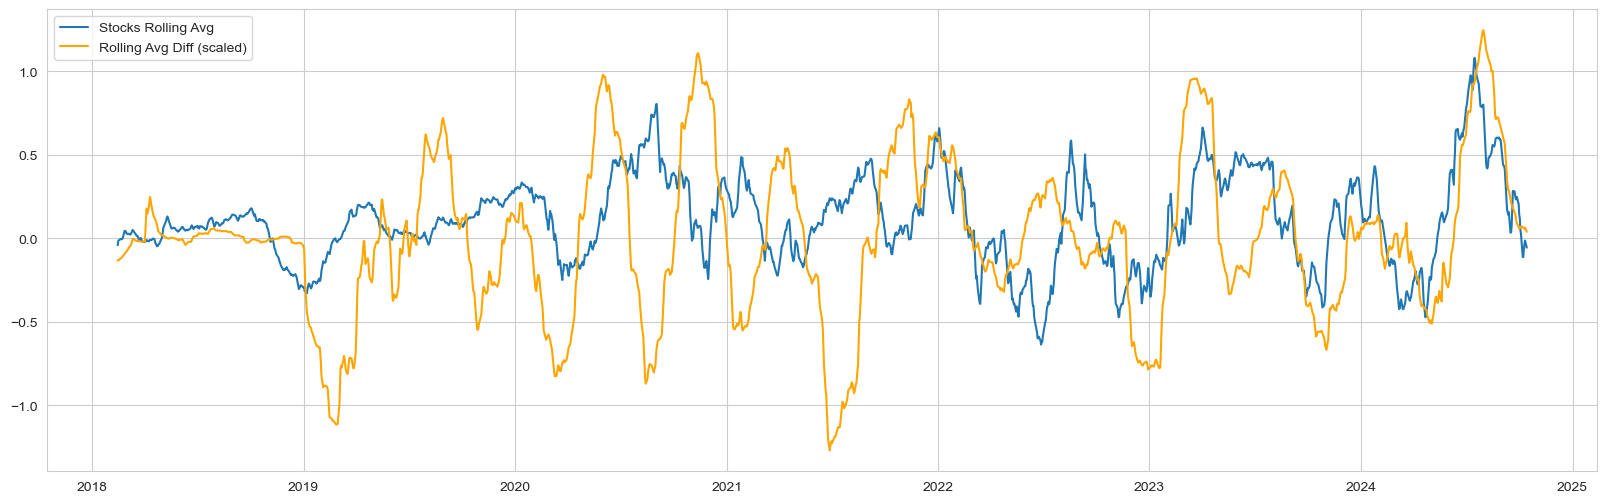

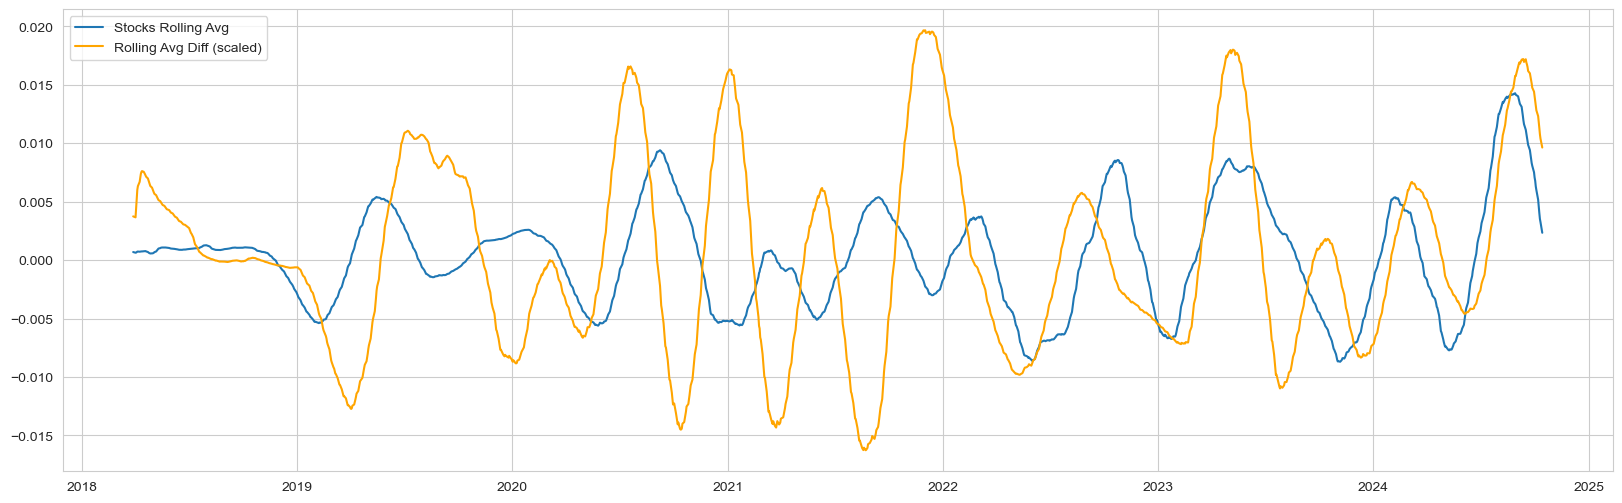

Pearson correlation between rolling averages: 0.24379423611195342
Kendall’s Tau correlation: 0.1298492997361206, p-value: 1.6152826427523038e-15
Pearson correlation: 0.2437942361119533, p-value: 4.090032099533159e-24


In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import kendalltau


stocks_diff = stocks['Close'].diff().dropna()
rolling_avg_diff = output['RollingAvg_AC'].diff().dropna()

stocks_rolling_avg = stocks_diff.rolling('90D', min_periods=30).mean()
rolling_avg_rolling = rolling_avg_diff.rolling('90D', min_periods=30).mean()
stocks_rolling_avg = stocks_rolling_avg.rolling('3D', min_periods=1).mean()
rolling_avg_rolling = rolling_avg_rolling.rolling('3D', min_periods=1).mean()

aligned_rolling_avg = pd.merge(stocks_rolling_avg.rename('stocks_rolling_avg'),
                               rolling_avg_rolling.rename('rolling_avg_rolling'),
                               left_index=True, right_index=True, how='inner').dropna()



plt.figure(figsize=(20, 6))
plt.plot(aligned_rolling_avg.index, aligned_rolling_avg["stocks_rolling_avg"], label='Stocks Rolling Avg')
plt.plot(aligned_rolling_avg.index, aligned_rolling_avg["rolling_avg_rolling"]*10, label='Rolling Avg Diff (scaled)', color='orange')
plt.legend()
plt.show()

second_diff_stocks = aligned_rolling_avg['stocks_rolling_avg'].diff()
second_diff_rolling_avg = aligned_rolling_avg['rolling_avg_rolling'].diff()

second_diff_stocks = second_diff_stocks.rolling('90D', min_periods=30).mean()
second_diff_rolling_avg = second_diff_rolling_avg.rolling('90D', min_periods=30).mean()
second_diff_stocks = second_diff_stocks.rolling('90D', min_periods=1).mean()
second_diff_rolling_avg = second_diff_rolling_avg.rolling('90D', min_periods=1).mean()

aligned_second_diff = pd.DataFrame({
    'second_diff_stocks': second_diff_stocks,
    'second_diff_rolling_avg': second_diff_rolling_avg
}).dropna()

plt.figure(figsize=(20, 6))
plt.plot(aligned_second_diff.index, aligned_second_diff["second_diff_stocks"], label='Stocks Rolling Avg')
plt.plot(aligned_second_diff.index, aligned_second_diff["second_diff_rolling_avg"]*10, label='Rolling Avg Diff (scaled)', color='orange')
plt.legend()
plt.show()

correlation = aligned_rolling_avg['stocks_rolling_avg'].corr(aligned_rolling_avg['rolling_avg_rolling'])
print(f"Pearson correlation between rolling averages: {correlation}")

corr_kendall, p_value_kendall = kendalltau(aligned_rolling_avg['stocks_rolling_avg'], aligned_rolling_avg['rolling_avg_rolling'])
print(f"Kendall’s Tau correlation: {corr_kendall}, p-value: {p_value_kendall}")

corr, p_value = pearsonr(aligned_rolling_avg['stocks_rolling_avg'], aligned_rolling_avg['rolling_avg_rolling'])
print(f"Pearson correlation: {corr}, p-value: {p_value}")

In [88]:

# Align the two time series based on their date indices
aligned_diff = pd.merge(stocks_diff, rolling_avg_diff, left_index=True, right_index=True, how='inner')

# Calculate correlation between the gradients using pandas
correlation = aligned_diff['Close_diff'].corr(aligned_diff['RollingAvg_diff'])
print(f"Correlation of gradients: {correlation}")

# Optionally, calculate correlation using scipy
corr, p_value = pearsonr(aligned_diff['Close_diff'], aligned_diff['RollingAvg_diff'])
print(f"Pearson correlation of gradients: {corr}, p-value: {p_value}")

KeyError: 'Close_diff'

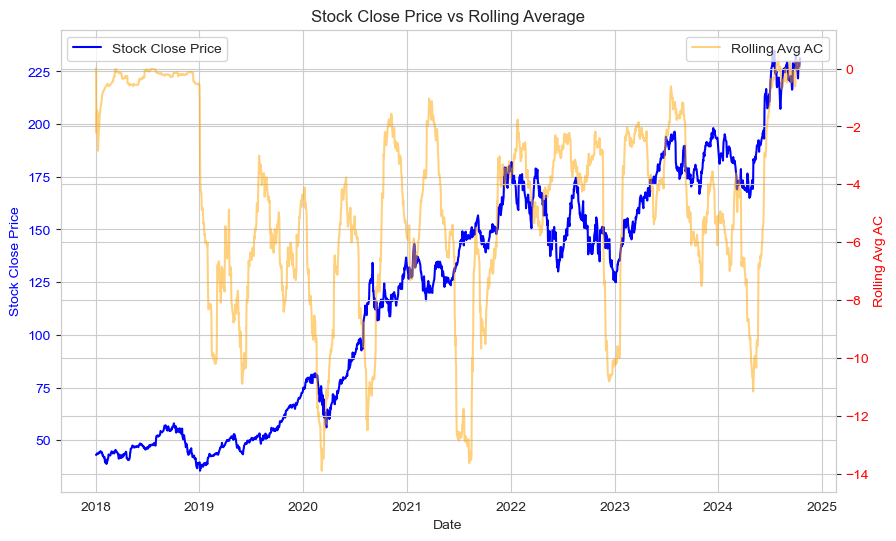

In [214]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stocks.index, stocks.Close, label='Stock Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(output.index, output.RollingAvg_AC, label='Rolling Avg AC', color='orange', alpha=0.5)
ax2.set_ylabel('Rolling Avg AC', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Stock Close Price vs Rolling Average')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

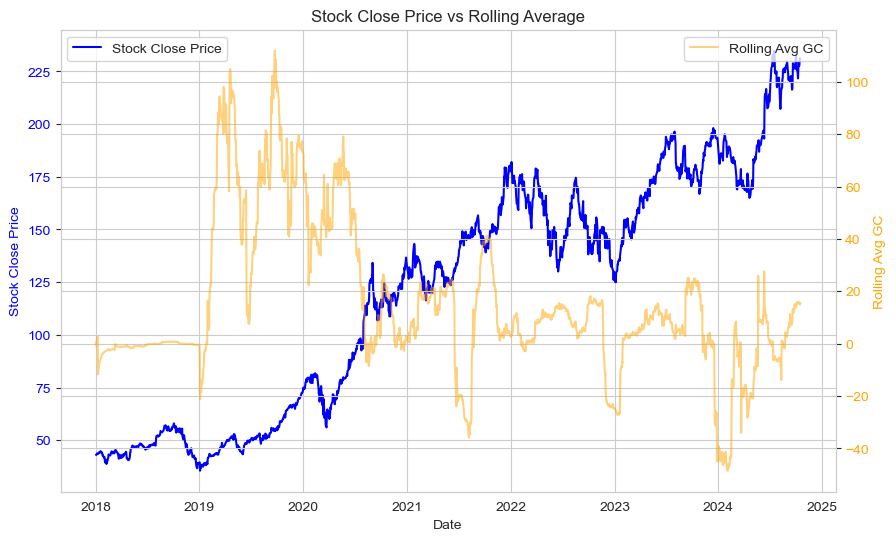

In [193]:
stocks
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stocks.index, stocks.Close, label='Stock Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(output.index, output.RollingAvg_GC, label='Rolling Avg GC', color='orange', alpha=0.5)
ax2.set_ylabel('Rolling Avg GC', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Stock Close Price vs Rolling Average')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

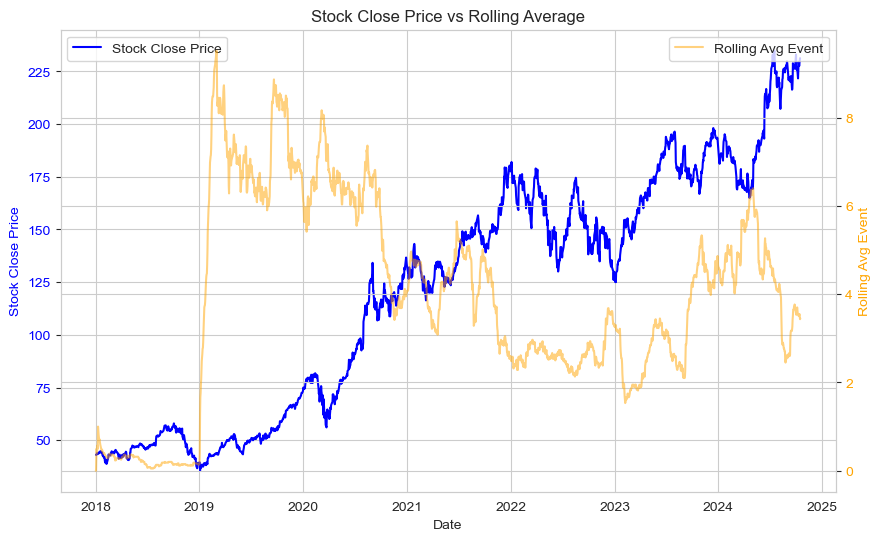

In [216]:
stocks
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stocks.index, stocks.Close, label='Stock Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(output.index, output.RollingAvg_Events, label='Rolling Avg Event', color='orange', alpha=0.5)
ax2.set_ylabel('Rolling Avg Event', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Stock Close Price vs Rolling Average')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()